In [119]:
from advectionGPdatasets.roundhill import RoundHill
from advectionGPdatasets import proposeboundary
#from advectionGP.models import AdjointAdvectionDiffusionModel as Model
from advectionGP.mfmodels import MeshFreeAdjointAdvectionDiffusionModel as Model
from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.wind import WindSimple
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
%matplotlib inline

In [188]:
X = []
Y = []
D = 0.5
for x in np.linspace(30,100,10):
    for y in np.linspace(30,100,10):
        for t in np.linspace(0,60,5):
            blobcentre = np.array([t+10,t+20]) #1m/s
            blobsize = np.sqrt(2*2*D*(t+5))
            d = np.linalg.norm(np.array([x,y])-blobcentre)
            #v = d
            v = 100000*norm(0,blobsize).pdf(d)
            
            X.append([t,t+10,x,y])
            Y.append(v)
X = np.array(X)
Y = np.array(Y)
Y /= np.std(Y)

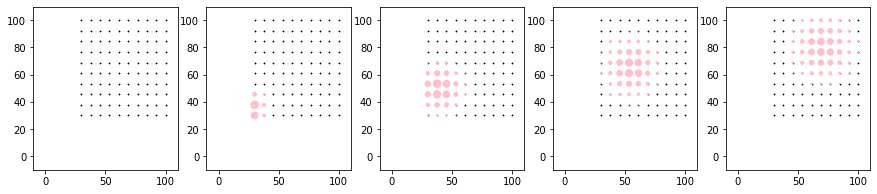

In [189]:
plt.figure(figsize=[15,3])
for i,t in enumerate(np.linspace(0,60,5)):
    plt.subplot(1,5,i+1)
    keep = X[:,0]==t
    plt.scatter(X[:,2],X[:,3],0.1,color='black')
    plt.scatter(X[keep,2],X[keep,3],Y[keep]*10-1,color='pink')
    plt.xlim([-10,110])
    plt.ylim([-10,110])
    #plt.axis('equal')

In [190]:
boundary = proposeboundary(X)
boundary[0][1]=-10 #puts the source on the grid!
boundary[0][2]=-10

In [191]:
boundary

([-7.0, -10, -10], [77.0, 107.0, 107.0])

In [192]:
len(X)

500

In [193]:
np.set_printoptions(precision=1,suppress=True)

In [194]:
np.array(boundary[1])-np.array(boundary[0])

array([ 84., 117., 117.])

(-15.850000000000001, 112.85, -15.850000000000001, 112.85)

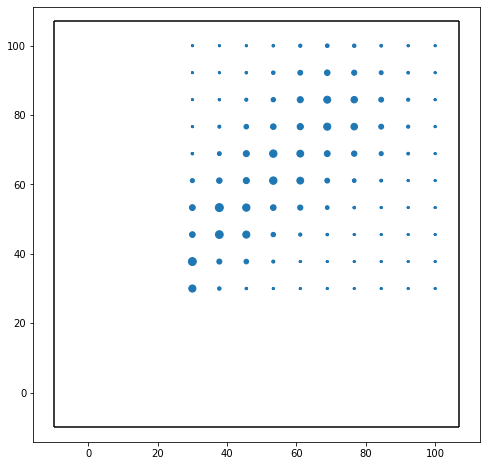

In [195]:
plt.figure(figsize=[8,8])
plt.scatter(X[:,2],X[:,3],3+Y*10)
plt.hlines([boundary[0][2],boundary[1][2]],boundary[0][1],boundary[1][1])
plt.vlines([boundary[0][1],boundary[1][1]],boundary[0][2],boundary[1][2])
#plt.plot([0],[0],'or')
plt.axis('equal')

In [207]:
#set up our model...
N_feat = 600 #Number of features used to infer the source
k = EQ(15, 1)
res = [100,50,50]
gbs = ((np.prod(res)*len(X)*8)/1024/1024/1000)
print("Memory usage in grid model: %0.2f Gb" % gbs)
#assert gbs<6, "TOO BIG :("
noiseSD = 0.02
sensors = FixedSensorModel(X,3)
windmodel=WindSimple(1,1)
k_0 = 0.5
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #Initiate new model for inference


Memory usage in grid model: 0.95 Gb


In [208]:
#dt: time grid size
#dx: x direction grid size
#dy: y direction grid size
#dx2 = dx**2
#dy2 = dy**2
#Nt: Number of evaluation points in time
#Nx: Number of evaluation points in x axis
#Ny: Number of evaluation points in y axis
mInfer.getGridStepSize()

(0.84, 2.34, 2.34, 5.475599999999999, 5.475599999999999, 100, 50, 50)

In [209]:
mInfer.computeModelRegressors(Nparticles=80) # Compute regressor matrix
meanZ, covZ = mInfer.computeZDistribution(Y) # Infers z vector mean and covariance using regressor matrix
sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
concInfer=mInfer.computeConcentration(sourceInfer) # Generates estimated concentration from inferred source

Initialising particles...
Diffusing particles...


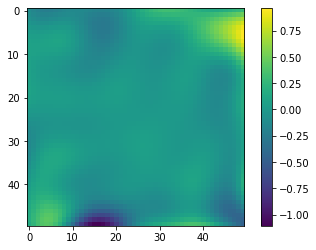

In [210]:
plt.imshow(sourceInfer[0,:,:])
plt.colorbar()

In [211]:
tgrid = []
ts = np.unique(X[:,1])
for t in np.unique(X[:,1]):
    tgrid.append(mInfer.getGridCoord([t,0,0])[0])
tgrid

source_samples = []
conc_samples=[]    
for z_samp in np.random.multivariate_normal(meanZ, covZ,5):
    print(".",end="")
    s = mInfer.computeSourceFromPhi(z_samp)
    source_samples.append(s)
    #conc_samples.append(mInfer.computeConcentration(s))
    
source_samples=np.array(source_samples)
#conc_samples=np.array(conc_samples)

source_lower_ci = np.percentile(source_samples,2.5,0)
source_upper_ci = np.percentile(source_samples,97.5,0)
source_mean = np.percentile(source_samples,50,0)

#conc_lower_ci = np.percentile(conc_samples,2.5,0)
#conc_upper_ci = np.percentile(conc_samples,97.5,0)
#conc_mean = np.percentile(conc_samples,50,0)


.....

(-0.5, 49.5, 49.5, -0.5)

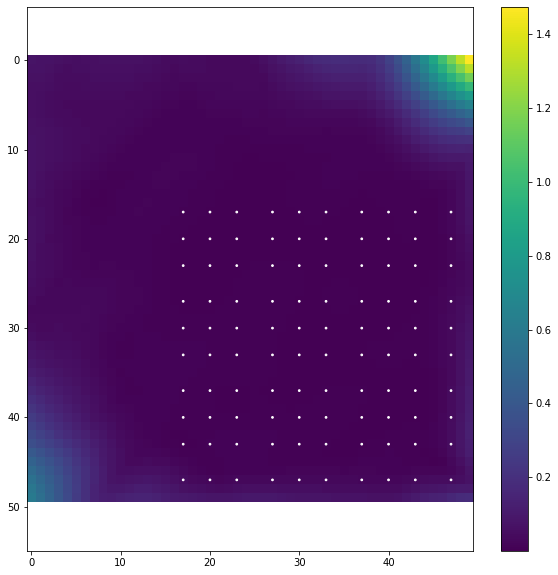

In [243]:
tstep = 0
Xgrid = mInfer.getGridCoord(X[:,[0,2,3]])
t = ts[tstep]
plt.figure(figsize=[10,10])
plt.imshow((source_upper_ci-source_lower_ci)[tgrid[tstep],:,:])
plt.colorbar()
#plt.plot(realsource[2],realsource[1],'xw')
plt.scatter(Xgrid[X[:,1]==t,2],Xgrid[X[:,1]==t,1],3+Y[X[:,1]==t]/10,color='w')
plt.axis('equal')

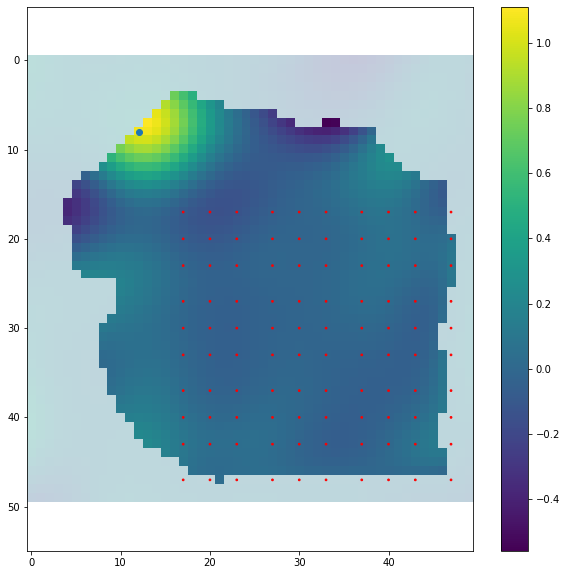

In [246]:
timepoint = 0
tp = tgrid[timepoint]
#tp = 0
conf = (source_upper_ci-source_lower_ci)[tgrid[timepoint],:,:]
source = sourceInfer[tp,:,:].copy()
source[conf>0.025]=np.NaN

plt.figure(figsize=[10,10])
plt.imshow(sourceInfer[tp,:,:],clim=[-4,6],alpha=0.3)
plt.imshow(source)#,clim=[-4,6])
plt.colorbar()
#plt.plot(realsource[2],realsource[1],'xw')
plt.scatter(Xgrid[X[:,1]==ts[timepoint],2],Xgrid[X[:,1]==ts[timepoint],1],3+Y[X[:,1]==ts[timepoint]]/100,color='red')
plt.axis('equal')
plt.plot(12,8,'o')

In [241]:
mInfer.getGridCoord(np.array([0,10,20]))

array([ 8,  8, 12])